# ResNet RNN to predict next state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state

importing Jupyter notebook from Process_Training_Data_2.ipynb


### Get the data
First Import it using pandas

In [5]:
file = "OSPA_training_data.csv"

In [6]:
STEPS=10

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)
exteneded_dataset= add_end_state(dataset_distances)

action_vector = ["A0","A1"]
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)

#dataset2 = group_by_path(normed_dataset)

In [7]:
Zero_Target= [0,0,0,0,0,0]
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

D0    0.0
D1    0.0
D2    0.0
D3    0.0
D4    0.0
D5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [8]:
def multivariate_data(dataset, target, start_index, end_index):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i,indices,:])

    labels.append(target[i, 1:])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [9]:
np.random.shuffle(dataset2)

In [10]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None)

In [29]:
x_train_single_sequential.shape

(192, 10, 6)

### Build the model

In [11]:
from keras.layers import Input, Dense, Add, LSTM
from keras.models import Model

states = Input(shape=(None,6))
RL = LSTM(11, return_sequences=True)(states)
F = Dense(6, activation='linear')(RL)
out = Add()([states, F])
single_step_sequential_model = Model(inputs=states, outputs=out)

loss_fn = tf.keras.losses.MeanSquaredError()

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_fn, metrics=['mse','mae'])

Using TensorFlow backend.


### Inspect the model

In [12]:
single_step_sequential_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 11)     792         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 6)      72          lstm_1[0][0]                     
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, 6)      0           input_1[0][0]                    
                                                                 dense_1[0][0]              

### Train the model

In [13]:
BATCH_SIZE = 1
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 100

single_step_sequential_history = single_step_sequential_model.fit(x= x_train_single_sequential, y= y_train_single_sequential, batch_size =  BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_single_sequential,y_val_single_sequential))

Train on 192 samples, validate on 48 samples
Epoch 1/100
192/192 [==============================] - 4s 23ms/step - loss: 0.7372 - mse: 0.7372 - mae: 0.5173 - val_loss: 0.7190 - val_mse: 0.7190 - val_mae: 0.4721
Epoch 2/100
192/192 [==============================] - 2s 13ms/step - loss: 0.5834 - mse: 0.5834 - mae: 0.4476 - val_loss: 0.5793 - val_mse: 0.5793 - val_mae: 0.4253
Epoch 3/100
192/192 [==============================] - 2s 13ms/step - loss: 0.4541 - mse: 0.4541 - mae: 0.3963 - val_loss: 0.4606 - val_mse: 0.4606 - val_mae: 0.3767
Epoch 4/100
192/192 [==============================] - 3s 15ms/step - loss: 0.3599 - mse: 0.3599 - mae: 0.3496 - val_loss: 0.3909 - val_mse: 0.3909 - val_mae: 0.3422
Epoch 5/100
192/192 [==============================] - 3s 15ms/step - loss: 0.3133 - mse: 0.3133 - mae: 0.3221 - val_loss: 0.3561 - val_mse: 0.3561 - val_mae: 0.3227
Epoch 6/100
192/192 [==============================] - 3s 13ms/step - loss: 0.2884 - mse: 0.2884 - mae: 0.3070 - val_loss: 0.

In [14]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [15]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

Visualize the model's training progress.

In [16]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

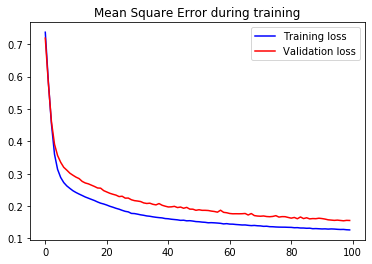

In [17]:
plot_train_history(single_step_sequential_history,
                   'Mean Square Error during training')

#### Adding early stop

In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(x= x_train_single_sequential, y= y_train_single_sequential, epochs=EPOCHS,batch_size =  BATCH_SIZE, validation_data=(x_val_single_sequential,  y_val_single_sequential), verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0788,  mae:0.1613,  mse:0.0788,  val_loss:0.1147,  val_mae:0.1830,  val_mse:0.1147,  
.................................

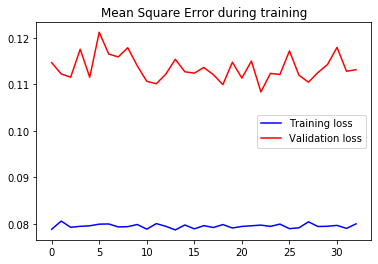

In [22]:
plot_train_history(early_history_sequential,
                   'Mean Square Error during training')

In [46]:
single_step_sequential_model.save("./data/S2S_ResNet_model_"+file+".h5") 

## Decoder Mode

In [47]:
def generate_trajectory_Decoder(model, start, target, initial_action, data_stats):

    model.reset_states()

    # initialize cost
    cost = 0

    # Empty vector to store the actions
    actions = []

    #initialize action vector
    actions.append(initial_action)

    # First point is the initial distance

    # Compute the initial distance
    distance_long = target - start
    
    # normalize to get the Neuronal Network input
    distance = norm(distance_long[0:6], data_stats)
    trajectory_generated = tf.expand_dims([distance], 0)


    for i in range(100):

        dummy_trajectory=model.predict(trajectory_generated)
        last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

        if  (last_step[0,0,0] <= 0.02):
            last_step[0,0,0] = 0
            trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
            end_message = "End"
            break

        trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
        end_message = "Error"
    

    New_trajectory = np.squeeze(trajectory_generated)

    trajectory_generated_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    return trajectory_generated_denorm, cost, actions, end_message


## Get validation statistics

In [48]:
model = tf.keras.models.load_model("./data/S2S_ResNet_model_"+file+".h5")
#model = tf.keras.models.load_model("./data/S2S_S2S_model_2_OSPA_training_data 2.csv.h5")

2.4542054049953888


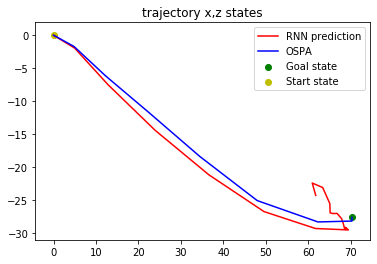

In [50]:
t_number = 4
S_Trajectory_prediction=x_val_single_sequential[t_number,0,:]
S_Trajectory_prediction = np.reshape(S_Trajectory_prediction, (1,1,6))

for i in range(20):

    dummy_trajectory=model.predict(S_Trajectory_prediction)
    last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

    if  (last_step[0,0,0] <= 0.01):
        last_step[0,0,0] = 0
        S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)
        break
    S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)

New_trajectory = np.squeeze(S_Trajectory_prediction)

Trajectory_prediction_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)

min_len = min(len(y_val_denorm),len(Trajectory_prediction_denorm[1:]))

mse =sklearn.metrics.mean_squared_error(y_val_denorm[:min_len,0:2], Trajectory_prediction_denorm[1:min_len+1,0:2])

print(mse)


start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
target = x_val_denorm[0] + start

pred_trajectory_states = target - Trajectory_prediction_denorm
OSPA_trajectory_states =  target - y_val_denorm
OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

plt.figure()

plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='r', label='RNN prediction')
plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='b', label='OSPA')
plt.scatter(target[0],target[1], c='g', label='Goal state')
plt.scatter(start[0], start[1], c='y', label='Start state')
plt.title("trajectory x,z states")
plt.legend()

plt.show()


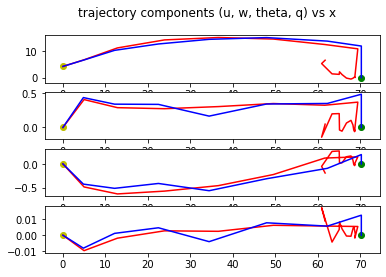

In [51]:
fig, axs = plt.subplots(4)

for i in range(4):

    component= i+2

    axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='r', label='RNN Prediction')
    axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='b', label='OSPA')
    axs[i].scatter(target[0],target[component], c='g', label='Goal state')
    axs[i].scatter(start[0], start[component], c='y', label='Start start')

fig.suptitle("trajectory components (u, w, theta, q) vs x")

fig.show()

In [52]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [53]:
def get_trajectory_results(x_single_sequential, y_single_sequential, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(y_single_sequential)):

        x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

        y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

        initial_action = [0,0]
        start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
        target = x_denorm[0] + start

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  target - y_denorm
        OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

        min_len = min(len(y_denorm),len(trajectory[1:]))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])

        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results


In [58]:
def get_trajectory_results_2(trajectoty_list, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(trajectoty_list)):

        initial_action = [0,0]
        start = trajectoty_list[t_number][0,-2]
        target = trajectoty_list[t_number][0,-1]

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        t_time = time.time() - start_time

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]

        min_len = min(len(OSPA_trajectory_states),len(trajectory))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])


        results.at[t_number, "time"] = t_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])
        results.at[t_number, "u_at_target"] = pred_trajectory_states[-1,2]
        results.at[t_number, "v_at_target"] =distance_error(pred_trajectory_states[-1,2], pred_trajectory_states[-1,3])
        results.at[t_number, "theta_at_target"] = pred_trajectory_states[-1,4]
        "u_at_target"

    return results

In [54]:
def results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["all","result_end", "result_error"])
    
    for metric in metrics:
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

## Compare with heuristic results

In [16]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [42]:
def get_heuristic_results(samples):
    results= samples.copy()
    for sample_id, row in results.iterrows():
        print(sample_id)
        initial_action = np.array(results['h_actions'][sample_id][0])
        start = np.array(results['initial_state'][sample_id])
        target = np.array(results['final_state'][sample_id])
        start_time = time.time()
        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
        results.at[sample_id, "h_time"] = time.time() - start_time
        results.at[sample_id, "h_actions"] = np.array(actions)
        results.at[sample_id, "h_path"] = np.array(trajectory)
        results.at[sample_id, "h_cost"] = cost
        results.at[sample_id, 'h_distance'] = distance_error(*trajectory[-1,0:2])
        results.at[sample_id, 'end_message'] = end_message
    return results

In [43]:
def heuristic_results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["sample", "result_end", "result_error", "all results"])
    
    for metric in metrics:
        comparsion_table.at[metric, "sample"] = samples[metric].mean()
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

In [ ]:
#results = get_heuristic_results(samples)
#metrics = ["h_time","h_distance","h_cost"]
#heuristic_results_summary(results, metrics)

In [41]:
col = ['D0','D1','D2','D3','D4','D5']
distances = []
for sample_id, row in samples.iterrows():
    target = np.array(results['final_state'][sample_id])
    for sample in  samples['h_path'][sample_id]:
        distances.append(target[0:6]-sample[0:6])
distances = np.array(distances)
df = pd.DataFrame (distances, columns = col)
data_stats_T = df.describe()
data_stats_T = data_stats_T.transpose()

KeyError: 'final_state'

## Datos globales

In [55]:
dataset_trajectories = dataset[["id_camino","C0",'C1',"C2","C3",'C4',"C5","A0","A1","initial_state", "goal_state"]]

In [56]:
trajectory_list = group_by_path(dataset_trajectories)

In [59]:
full_results= get_trajectory_results_2(trajectory_list, data_stats)

the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


In [60]:
metrics = ["time",'distance_to_target', "u_at_target","v_at_target","theta_at_target","mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value"]
results_summary(full_results, metrics)

0.09583333333333334


,all,result_end,result_error
time,1.44214,0.761773,7.86123
distance_to_target,10.0767,3.31191,73.901
u_at_target,-0.555971,4.00547,-43.5922
v_at_target,13.6598,9.68748,51.1379
theta_at_target,0.259899,0.312216,-0.233699
mean_distance_in_trajectory,1.53027,1.55041,1.34025
sqrt(trajectory MSE),2.051,2.08682,1.71301
k_value,0.354392,0.355251,0.346288


In [61]:
def plot_trajectory(x_single_sequential, y_single_sequential, data_stats, t_number):
    
    x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

    y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_denorm[0] + start


    trajectory= model.predict(tf.expand_dims(x_single_sequential[t_number],0))

    New_trajectory = np.squeeze(trajectory)

    trajectory_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    pred_trajectory_states = target - trajectory_denorm
    OSPA_trajectory_states =  target - y_denorm
    OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)
    pred_trajectory_states=np.insert(pred_trajectory_states,0,start, axis=0)
  
    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

In [62]:
def plot_trajectory_2(trajectory_list, data_stats, t_number):

    initial_action = [0,0]
    start = trajectory_list[t_number][0,-2]
    target = trajectory_list[t_number][0,-1]

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    pred_trajectory_states = target - trajectory
    OSPA_trajectory_states =  trajectory_list[t_number][:,0:6]
    # ANN_trajectory_states = ANN_dataset["states"][t_number]


    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='g', label='RNN prediction')
    # plt.plot(ANN_trajectory_states[:,0], ANN_trajectory_states[:,1], c='b', label="ANN prediction")
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='r', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='b', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='r', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, v, theta, q) vs x")

    fig.show()

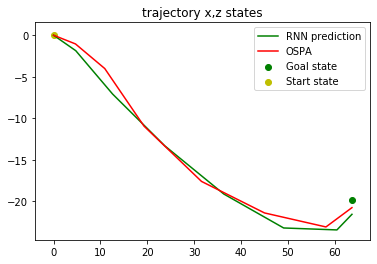

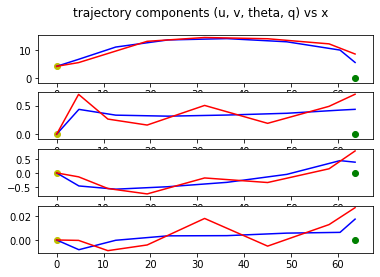

In [85]:
t_number = 126
plot_trajectory_2(trajectory_list, data_stats, t_number)

In [69]:
# full_results[["distance_to_target", "mean_distance_in_trajectory", "sqrt(trajectory MSE)"]].sort_values(by=["mean_distance_in_trajectory"])[-10:-1]

,distance_to_target,mean_distance_in_trajectory,sqrt(trajectory MSE)
152,1.892571,6.126048,4.517438
93,0.974089,6.140193,4.388592
207,1.595366,6.363929,4.648680
239,1.600489,6.517836,4.701300
83,2.595404,7.145711,4.943786
235,1.098221,7.505903,5.182185
156,1.586122,8.694375,5.293008
85,0.264131,9.537998,6.152301
146,2.252134,10.611320,6.100292


In [105]:
# k_results = pd.DataFrame(columns = ["k_value","time","distance_to_target", "mean_distance_in_trajectory", "sqrt(trajectory MSE)"])
# i = 0
# last_percentaje=0
# for percentaje in np.linspace(0.2, 1, num=5):
#     k_results.at[i,'k_value']= percentaje
#     k_results.at[i,"time"]= full_results[["time"]].loc[(full_results['k_value'] <= percentaje) & (full_results['k_value'] > last_percentaje)].mean()
#     k_results.at[i,"distance_to_target"]= full_results[["distance_to_target"]].loc[(full_results['k_value'] <= percentaje) & (full_results['k_value'] > last_percentaje)].mean()
#     k_results.at[i,"mean_distance_in_trajectory"]= full_results[["mean_distance_in_trajectory"]].loc[(full_results['k_value'] <= percentaje) & (full_results['k_value'] > last_percentaje)].mean()
#     k_results.at[i,"sqrt(trajectory MSE)"]= full_results[["sqrt(trajectory MSE)"]].loc[(full_results['k_value'] <= percentaje) & (full_results['k_value'] > last_percentaje)].mean()
#     i=i+1
#     last_percentaje = percentaje


In [19]:
# raw_dataset = pd.read_csv("./data/ANN_results.csv")
# ANN_dataset = raw_dataset.copy()

# for index, row in ANN_dataset.iterrows():
#     CS_array =np.array(eval(row["states"]))
#     ANN_dataset["states"][index] = CS_array

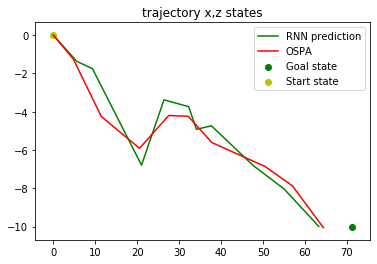

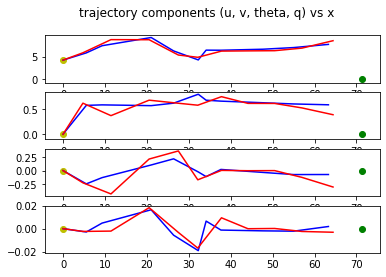

In [114]:
plot_trajectory(x_val_single_sequential, y_val_single_sequential, data_stats, 3)

In [80]:
validation_results= get_trajectory_results(x_val_single_sequential, y_val_single_sequential, data_stats)

In [83]:
results_summary(validation_results, metrics)

0.0


,all,result_end,result_error
time,0.475037,0.475037,NaN
distance_to_target,1.39928,1.39928,NaN
u_at_target,7.58886,7.58886,NaN
v_at_target,7.60216,7.60216,NaN
theta_at_target,0.200925,0.200925,NaN
mean_distance_in_trajectory,1.59412,1.59412,NaN
sqrt(trajectory MSE),4.9858,4.9858,NaN
k_value,0.350669,0.350669,NaN
